#### 2019/09/14 Notes
-
1. raw data拿到就先分<span style="color:red">**大中小公司**</span>，再去做基本統計量
2. 第三部分的實作需要<span style="color:red">**價量資料**</span>
3. 資料的部分，最早應該要從2010/1/1開始抓
-
1. 成交量/成交量週轉率 @ijen @juu

<img src="https://i.imgur.com/YZ8f21o.jpg" height="400" width="400">
<img src="https://i.imgur.com/VRp7NCJ.jpg" height="400" width="400">

### Document

<img src="https://i.imgur.com/1giFKNu.png">

### 第一部分：
- 基本統計量說明: Raw Data在當沖前/當沖後的各種基本統計量陳述（平均數、中位數、min、max、標準差），對Raw Data有個基本的概念

### 第二部分：
- 當沖前/當沖後的各種基本統計量的檢定（ex:現股當沖比重、日報酬率、週報酬率、月報酬率）
- 做平均數檢定、中位數檢定，看看當沖前/當沖後這些基本統計量有沒有顯著變化

### 第三部分：
- 政策面的研究。政府開放當沖是為了縮小spread、提高成交量、提高成交量週轉率。
- 研究data做的回歸是不是符合政府所宣稱的?當沖真的有穩定市場嗎？對資本市場有貢獻嗎？

### 第四部分：
- 市場面研究。有沒有其他在市場上面的因素會影響我們的回歸式？要控制這些變數，放入回歸式（很多x)

### $ \Delta $ $上市公司日報酬率標準差_i$ = $a_0$ + $a_1$ * (上市公司現股當沖比重平均)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
import datetime as datetime
import json
import os
from datetime import timedelta
warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn.linear_model import LinearRegression
from scipy import stats

In [2]:
ls

20100101_20190913_data.csv  20130613_20190620_data.csv
20100101_20190913_data.rar  20190718.ipynb


In [3]:
outside_test = pd.read_csv("20100101_20190913_data.csv")
outside_test.head()

,證券代碼,Data Field,2010/1/4,2010/1/5,2010/1/6,2010/1/7,2010/1/8,2010/1/11,2010/1/12,2010/1/13,...,2019/8/30,2019/9/2,2019/9/3,2019/9/4,2019/9/5,2019/9/6,2019/9/9,2019/9/10,2019/9/11,2019/9/12
0,1101 台泥,日報酬率 %,0.8824,3.4985,2.1127,-1.9310,-0.4219,-1.8362,-0.5755,-1.5919,...,1.7196,-0.5202,0.2614,0.2608,1.4304,2.1795,0.3764,-0.1250,0.1252,0.1250
1,1101 台泥,週報酬率 %,0.2924,4.8744,6.6177,4.5589,4.1178,1.3120,-2.6760,-6.2068,...,0.6545,1.4589,1.8592,1.9894,3.1746,3.6410,4.5751,4.1721,4.0312,0.5019
2,1101 台泥,月報酬率 %,1.7804,5.3412,7.5667,4.7129,4.5792,2.0559,1.4686,-0.1467,...,-0.3199,1.7801,2.0461,2.3122,3.7757,6.6498,5.5881,5.4561,5.5882,5.5999
3,1101 台泥,現股當沖比重,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,11.4300,9.0100,9.5500,6.3400,14.0600,15.9800,12.2300,12.0500,12.4300,11.3100
4,1102 亞泥,日報酬率 %,-0.1445,2.1708,0.7082,-1.1252,0.5690,-0.7072,0.7123,-1.1315,...,2.0166,1.5116,1.4891,-0.5643,0.0000,-0.4540,1.4823,-1.4607,-0.4561,0.3436


### tw_day_trade class 

In [18]:
class tw_day_trade():
    def __init__(self):
        self.pos_1 = ""
        self.pos_2 = ""
        self.pos_3 = ""
        self.df_before = "" 
        self.df_after = ""  
        self.basic_stock_stats_info_dict = {}
        self.x = "" 
        self.y_daily = "" 
        self.y_weekly = "" 
        self.y_monthly = "" 

        """
        data basic info
        """
        self.day_trade_data = pd.read_csv("20100101_20190913_data.csv")
        self.company_num = len(self.day_trade_data)/4
        print("data 台灣上市公司總數: {} 間".format(self.company_num))
        print("data shape: {}".format(self.day_trade_data.shape))

        """
        當沖相關重要日期們
        """
        self.open_single_day_trade_date = '2014/1/6' # 開放單向當沖
        self.open_double_day_trade_date = '2014/6/30' # 開放雙向當沖
        self.tax_down_day_trade_date = '2017/4/28' # 調降當沖稅率
        
    
    def day_trade_split(self, date_1, date_2, date_3):
        """
        根據date_1, date_2, date_3來切割dataframe
        """
        tmp_arr = np.array(list(self.day_trade_data))
        self.pos_1 = np.where(tmp_arr==date_1)[0][0]
        self.pos_2 = np.where(tmp_arr==date_2)[0][0]
        self.pos_3 = np.where(tmp_arr==date_3)[0][0]
        print("date_1 pos: {}\ndate_2 pos: {}\ndate_3 pos: {}".format(self.pos_1,self.pos_2,self.pos_3))
        
        self.df_before = self.day_trade_data.iloc[:,self.pos_1:self.pos_2]
        self.df_after = self.day_trade_data.iloc[:,self.pos_2:(self.pos_3+1)]
        print("df_before shape: {}".format(self.df_before.shape))
        print("df after shape: {}".format(self.df_after.shape))
        
        
    def day_trade_stats(self):
        """
        第一部分：計算當沖前/當沖後的基本統計量，對Raw Data有個基本概念
        """
        
        # 平均數 (axis=1橫條往右apply func., axis=0是直條往下apply func.)
        self.df_before['mean_before'] = self.df_before.mean(axis=1)
        self.df_after['mean_after'] = self.df_after.mean(axis=1)
        
        mean_before_daily = self.df_before['mean_before'][0::4].mean()
        mean_after_daily = self.df_after['mean_after'][0::4].mean()
        mean_before_weekly = self.df_before['mean_before'][1::4].mean()
        mean_after_weekly = self.df_after['mean_after'][1::4].mean()
        mean_before_monthly = self.df_before['mean_before'][2::4].mean()
        mean_after_monthly = self.df_after['mean_after'][2::4].mean()
        mean_cash_after = self.df_after['mean_after'][3::4].mean()
        
        # 標準差 
        self.df_before['std_before'] = self.df_before.std(axis=1)
        self.df_after['std_after'] = self.df_after.std(axis=1)
        
        std_before_daily = self.df_before['std_before'][0::4].mean()
        std_after_daily = self.df_after['std_after'][0::4].mean()
        std_before_weekly = self.df_before['std_before'][1::4].mean()
        std_after_weekly = self.df_after['std_after'][1::4].mean()
        std_before_monthly = self.df_before['std_before'][2::4].mean()
        std_after_monthly = self.df_after['std_after'][2::4].mean()
        std_cash_after = self.df_after['std_after'][3::4].mean()
        
        # 中位數
        self.df_before['median_before'] = self.df_before.median(axis=1)
        self.df_after['median_after'] = self.df_after.median(axis=1)
        
        median_before_daily = self.df_before['median_before'][0::4].mean()
        median_after_daily = self.df_after['median_after'][0::4].mean()
        median_before_weekly = self.df_before['median_before'][1::4].mean()
        median_after_weekly = self.df_after['median_after'][1::4].mean()
        median_before_monthly = self.df_before['median_before'][2::4].mean()
        median_after_monthly = self.df_after['median_after'][2::4].mean()
        median_cash_after = self.df_after['median_after'][3::4].mean()
        
        # max
        max_before_daily = self.df_before['mean_before'][0::4].max()
        max_after_daily = self.df_after['mean_after'][0::4].max()
        max_before_weekly = self.df_before['mean_before'][1::4].max()
        max_after_weekly = self.df_after['mean_after'][1::4].max()
        max_before_monthly = self.df_before['mean_before'][2::4].max()
        max_after_monthly = self.df_after['mean_after'][2::4].max()
        max_cash_after = self.df_after['mean_after'][3::4].max()
        
        # min
        min_before_daily = self.df_before['mean_before'][0::4].min()
        min_after_daily = self.df_after['mean_after'][0::4].min()
        min_before_weekly = self.df_before['mean_before'][1::4].min()
        min_after_weekly = self.df_after['mean_after'][1::4].min()
        min_before_monthly = self.df_before['mean_before'][2::4].min()
        min_after_monthly = self.df_after['mean_after'][2::4].min()
        min_cash_after = self.df_after['mean_after'][3::4].min()
        
        
        # 存放基本統計量的dictionary
        self.basic_stock_stats_info_dict = {
            'mean':{'mean_before_daily':mean_before_daily,'mean_after_daily':mean_after_daily,
                   'mean_before_weekly':mean_before_weekly,'mean_after_weekly':mean_before_weekly,
                   'mean_before_monthly':mean_before_monthly,'mean_after_monthly':mean_after_monthly,
                   'mean_cash':mean_cash_after},
            
            'std':{'std_before_daily':std_before_daily, 'std_after_daily':std_after_daily,
                  'std_before_weekly':std_before_weekly, 'std_after_weekly':std_after_weekly,
                  'std_before_monthly':std_before_monthly, 'std_after_monthly':std_after_monthly,
                  'std_cash':std_cash_after},
            
            'median':{'median_before_daily':median_before_daily, 'median_after_daily':median_after_daily,
                  'median_before_weekly':median_before_weekly, 'median_after_weekly':median_after_weekly,
                  'median_before_monthly':median_before_monthly, 'median_after_monthly':median_after_monthly
                     ,'median_cash_after':median_cash_after},
            
            'max':{'max_before_daily':max_before_daily, 'max_after_daily':max_after_daily,
                  'max_before_weekly':max_before_weekly, 'max_after_weekly':max_after_weekly,
                  'max_before_monthly':max_before_monthly, 'max_after_monthly':max_after_monthly,
                  'max_cash_after':max_cash_after},
            
            'min':{'min_before_daily':min_before_daily, 'min_after_daily':min_after_daily,
                  'min_before_weekly':min_before_weekly, 'min_after_weekly':min_after_weekly,
                  'min_before_monthly':min_before_monthly, 'min_after_monthly':min_after_monthly,
                  'min_cash_after':min_cash_after},

        }
        
        print(json.dumps(self.basic_stock_stats_info_dict, indent=2))
        
        """
        第二部分：Raw Data各種基本統計量檢定
        """
        
        # 日/週/月報酬率平均數檢定
        print("日/週/月報酬率平均數檢定")
        print(stats.ttest_ind(self.df_before['mean_before'][0::4],self.df_after['mean_after'][0::4]))
        print(stats.ttest_ind(self.df_before['mean_before'][1::4],self.df_after['mean_after'][1::4]))
        print(stats.ttest_ind(self.df_before['mean_before'][2::4],self.df_after['mean_after'][2::4]))
        
        # 日/週/月報酬率標準差檢定
        print("日/週/月報酬率標準差檢定")
        print(stats.ttest_ind(self.df_before['std_before'][0::4],self.df_after['std_after'][0::4]))
        print(stats.ttest_ind(self.df_before['std_before'][1::4],self.df_after['std_after'][1::4]))
        print(stats.ttest_ind(self.df_before['std_before'][2::4],self.df_after['std_after'][2::4]))
        
        # 日/週/月報酬率中位數檢定
        print("日/週/月報酬率中位數檢定")
        print(stats.ttest_ind(self.df_before['median_before'][0::4],self.df_after['median_after'][0::4]))
        print(stats.ttest_ind(self.df_before['median_before'][1::4],self.df_after['median_after'][1::4]))
        print(stats.ttest_ind(self.df_before['median_before'][2::4],self.df_after['median_after'][2::4]))
        
    
              
    def day_trade_plot(self,df_type,date_freq):
        """
        Raw Data Data Visualization
        """
        if df_type == 'before':
            """
            plot for df_before
            """
            if date_freq == 'daily_mean':
                plt.figure(figsize=(16,6))

                plt.hist(x=self.df_before['mean_before'][0::4])
                plt.title('df_before Daily Return Mean')
                
            if date_freq == 'daily_std':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_before['std_before'][0::4])
                plt.title('df_before Daily Return Std')
            
            if date_freq == 'daily_median':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_before['median_before'][0::4])
                plt.title('df_before Daily Return Median')
            
            if date_freq == 'weekly_mean':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_before['mean_before'][1::4])
                plt.title('df_before Weekly Return Mean')
            
            if date_freq == 'weekly_std':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_before['std_before'][1::4])
                plt.title('df_before Weekly Return Std')
            
            if date_freq == 'weekly_median':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_before['median_before'][1::4])
                plt.title('df_before Weekly Return Median')
            
            if date_freq == 'monthly_mean':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_before['mean_before'][2::4])
                plt.title('df_before Monthly Return Mean')
            
            if date_freq == 'monthly_std':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_before['std_before'][2::4])
                plt.title('df_before Monthly Return Std')
            
            if date_freq == 'monthly_median':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_before['median_before'][2::4])
                plt.title('df_before Monthly Return Median')
            
            
        if df_type == 'after':
            if date_freq == 'daily_mean':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_after['mean_after'][0::4],color='green')
                plt.title('df_after Daily Return Mean')
            
            if date_freq == 'daily_std':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_after['std_after'][0::4],color='green')
                plt.title('df_after Daily Return Std')
            
            if date_freq == 'daily_median':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_after['median_after'][0::4],color='green')
                plt.title('df_after Daily Return Median')
            
            if date_freq == 'weekly_mean':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_after['mean_after'][1::4],color='green')
                plt.title('df_after Weekly Return Mean')
            
            if date_freq == 'weekly_std':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_after['std_after'][1::4],color='green')
                plt.title('df_after Weekly Return Std')
            
            if date_freq == 'weekly_median':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_after['median_after'][1::4],color='green')
                plt.title('df_after Weekly Return Median')
            
            if date_freq == 'monthly_mean':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_after['mean_after'][2::4],color='green')
                plt.title('df_after Monthly Return Mean')
            
            if date_freq == 'monthly_std':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_after['std_after'][2::4],color='green')
                plt.title('df_after Monthly Return Std')
            
            if date_freq == 'monthly_median':
                plt.figure(figsize=(16,6))
                plt.hist(x=self.df_after['median_after'][2::4],color='green')
                plt.title('df_after Monthly Return Median')
      
              
    def day_trade_calculate(self):
        """
        準備OLS的x和y
        """
        self.x = self.df_after['mean_after'][3::4]-self.df_before['mean_before'][3::4]
        self.y_daily = self.df_after['std_after'][0::4]-self.df_before['std_before'][0::4]
        self.y_weekly = self.df_after['std_after'][1::4]-self.df_before['std_before'][1::4]
        self.y_monthly = self.df_after['std_after'][2::4]-self.df_before['std_before'][2::4]
    
    
    def day_trade_OLS(self, date_freq):
        """
        根據傳進的date_freq，計算OLS(日/週/月)
        date_freq's value: 'daily','weekly','monthly'
        """
        if date_freq=='daily':
            self.x = sm.add_constant(self.x)
            self.y_daily = list(self.y_daily)
            model_daily = sm.OLS(self.y_daily, self.x).fit()
            print(model_daily.summary())

        if date_freq=='weekly':
            self.x = sm.add_constant(self.x)
            self.y_weekly = list(self.y_weekly)
            model_weekly = sm.OLS(self.y_weekly, self.x).fit()
            print(model_weekly.summary())

        if date_freq=='monthly':
            self.x = sm.add_constant(self.x)
            self.y_monthly = list(self.y_monthly)
            model_monthly = sm.OLS(self.y_monthly, self.x).fit()
            print(model_monthly.summary())

# 2014/1/6開放單向當沖，前後各抓半年
#### **<span style="color:green">pos_1 = 2013/6/13, pos_2 = 2014/1/6, pos_3 = 2014/6/30</span>**

data 台灣上市公司總數: 950.0 間
data shape: (3800, 2393)
date_1 pos: 855
date_2 pos: 998
date_3 pos: 1113
df_before shape: (3800, 143)
df after shape: (3800, 116)
{
  "mean": {
    "mean_before_daily": 0.0943838910563121,
    "mean_after_daily": 0.08745381488203266,
    "mean_before_weekly": 0.44025644534412955,
    "mean_after_weekly": 0.44025644534412955,
    "mean_before_monthly": 1.6101211210894368,
    "mean_after_monthly": 2.192933521778584,
    "mean_cash": 0.4267249546279491
  },
  "std": {
    "std_before_daily": 1.6459142435537404,
    "std_after_daily": 1.6280326157172076,
    "std_before_weekly": 3.616236163519183,
    "std_after_weekly": 3.496601309033987,
    "std_before_monthly": 7.07945711812483,
    "std_after_monthly": 6.910073588578449,
    "std_cash": 0.5139103943400404
  },
  "median": {
    "median_before_daily": -0.00018354582259845348,
    "median_after_daily": -0.01053783938294011,
    "median_before_weekly": 0.10516914758925285,
    "median_after_weekly": 0.16835272413

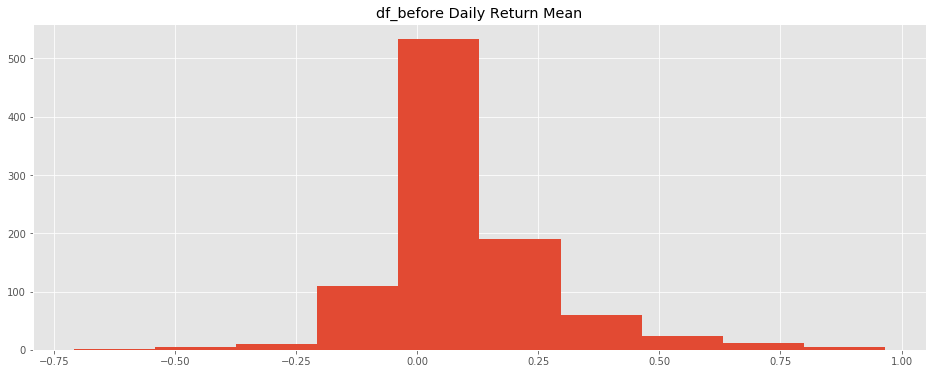

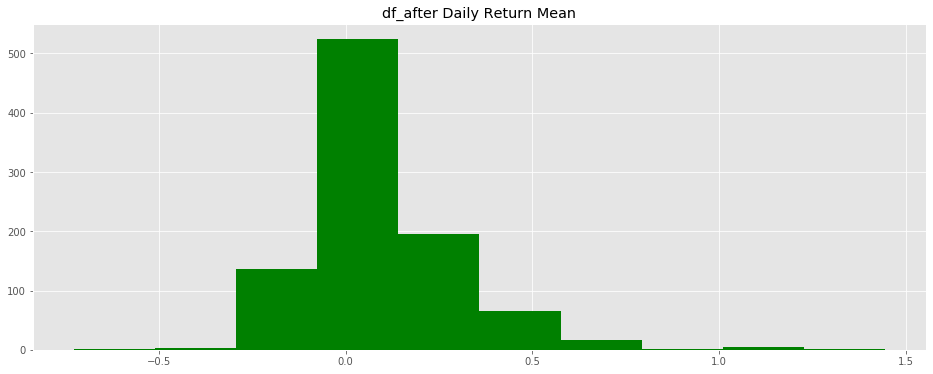

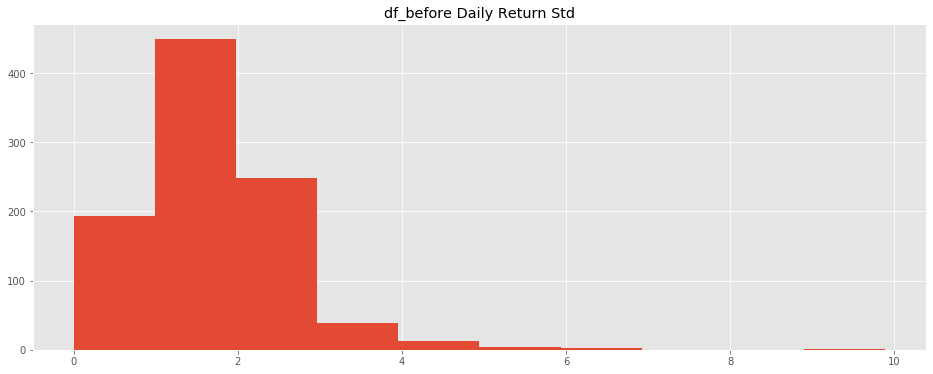

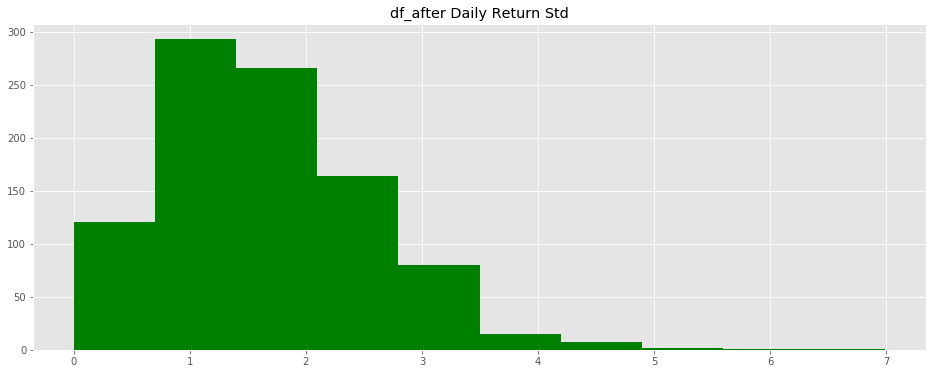

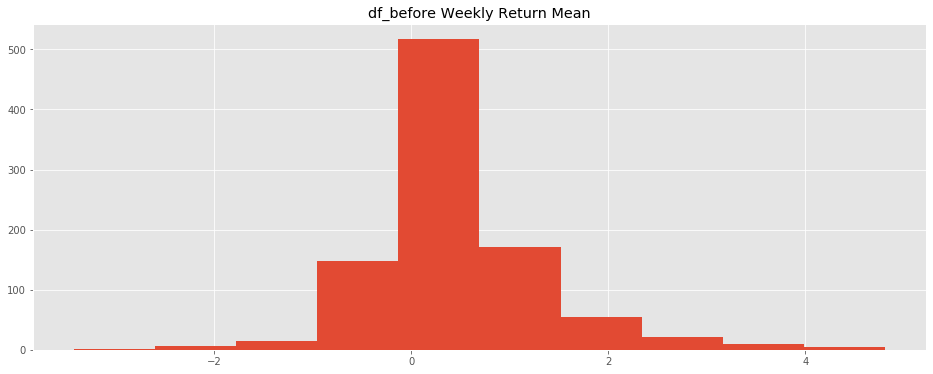

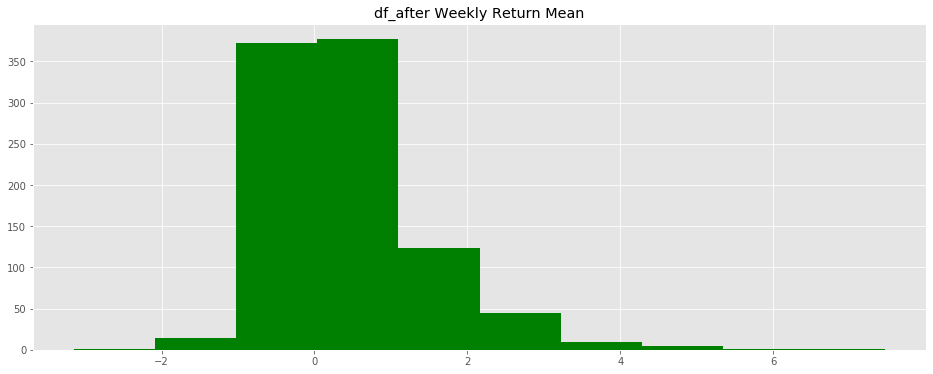

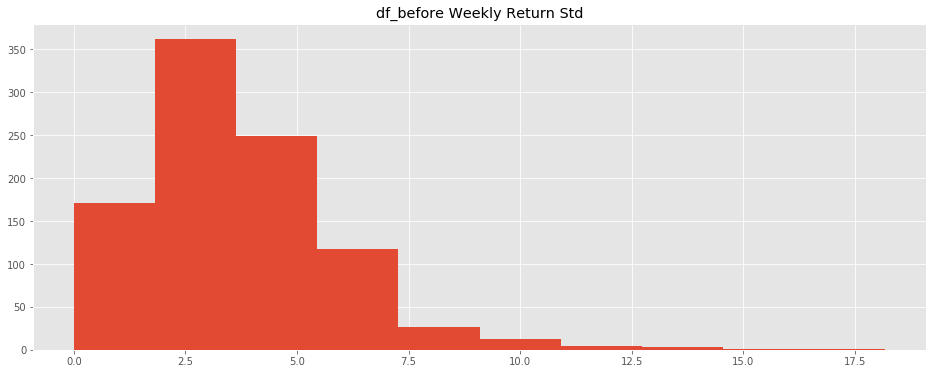

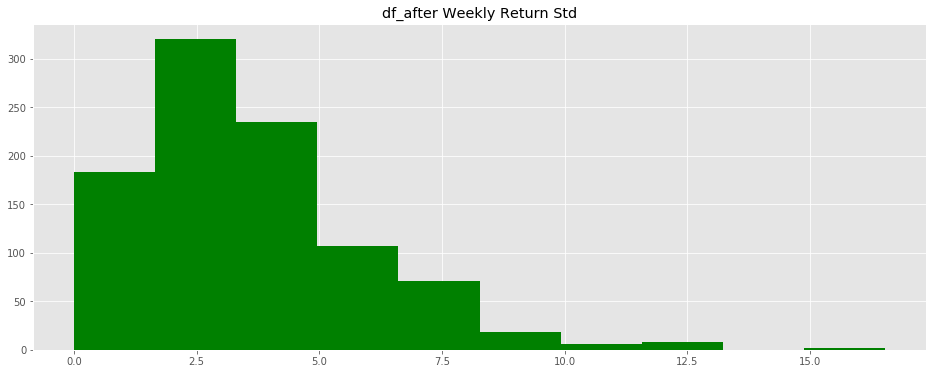

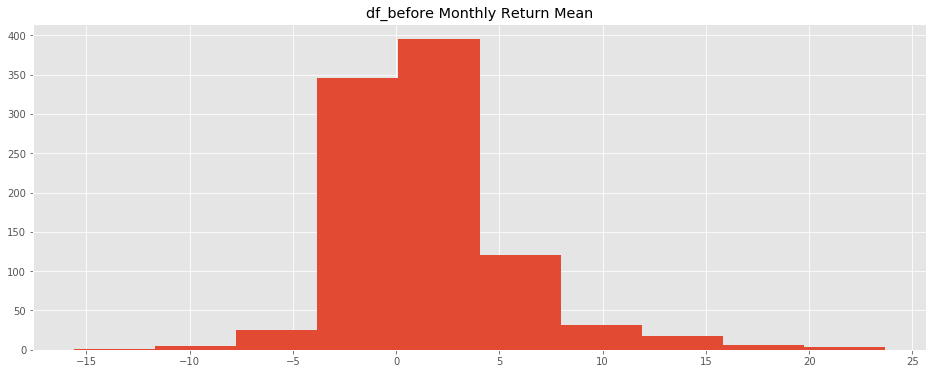

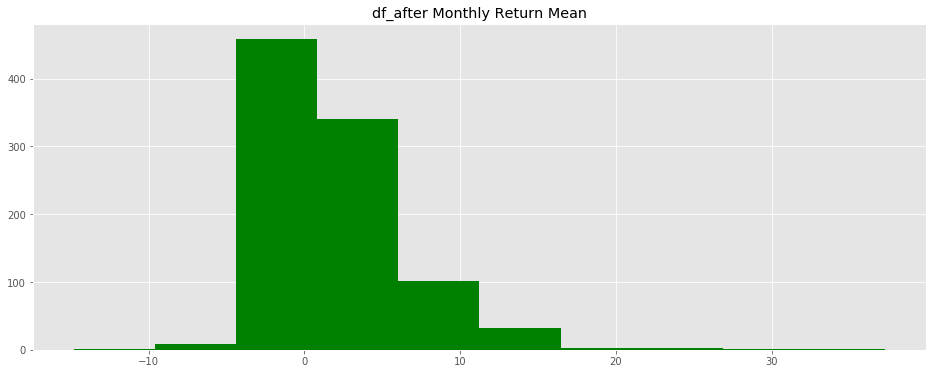

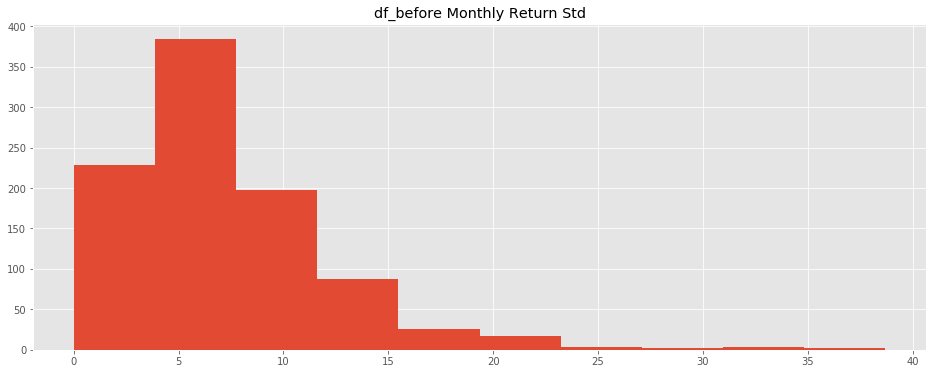

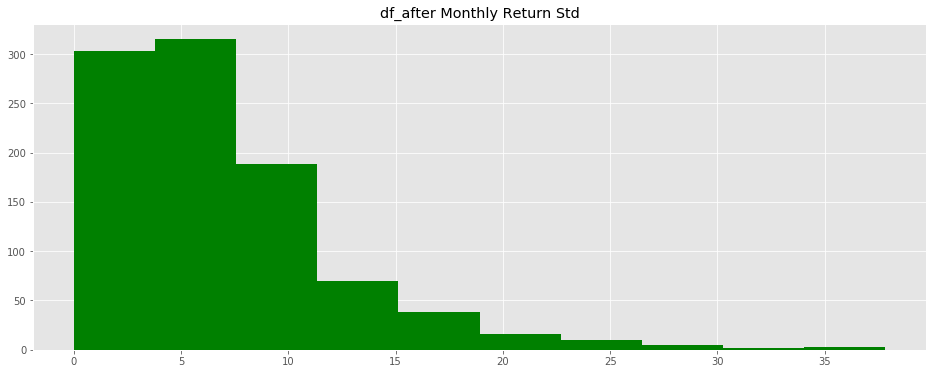

In [19]:
data_1=tw_day_trade()
data_1.day_trade_split('2013/6/13','2014/1/6','2014/6/30')
data_1.day_trade_stats()
data_1.day_trade_calculate()
data_1.day_trade_plot('before','daily_mean')
data_1.day_trade_plot('after','daily_mean')
data_1.day_trade_plot('before','daily_std')
data_1.day_trade_plot('after','daily_std')
data_1.day_trade_plot('before','weekly_mean')
data_1.day_trade_plot('after','weekly_mean')
data_1.day_trade_plot('before','weekly_std')
data_1.day_trade_plot('after','weekly_std')
data_1.day_trade_plot('before','monthly_mean')
data_1.day_trade_plot('after','monthly_mean')
data_1.day_trade_plot('before','monthly_std')
data_1.day_trade_plot('after','monthly_std')
data_1.day_trade_OLS('daily')
data_1.day_trade_OLS('weekly')
data_1.day_trade_OLS('monthly')

# 2014/6/30 開放雙向當沖，前後各抓半年
#### **<span style="color:green">pos_1 = 2013/12/30, pos_2 = 2014/6/30, pos_3 = 2014/12/30</span>**

data 台灣上市公司總數: 950.0 間
data shape: (3800, 2393)
date_1 pos: 994
date_2 pos: 1113
date_3 pos: 1242
df_before shape: (3800, 119)
df after shape: (3800, 130)
{
  "mean": {
    "mean_before_daily": 0.09312658735072976,
    "mean_after_daily": -0.00125278408619975,
    "mean_before_weekly": 0.5048735922158337,
    "mean_after_weekly": 0.5048735922158337,
    "mean_before_monthly": 2.289661171163202,
    "mean_after_monthly": -0.5090706116866971,
    "mean_cash": 0.6407607956900124
  },
  "std": {
    "std_before_daily": 1.633263906460997,
    "std_after_daily": 1.694217858878097,
    "std_before_weekly": 3.5220187568307733,
    "std_after_weekly": 3.7545731762396155,
    "std_before_monthly": 6.981460079132761,
    "std_after_monthly": 6.979760921206626,
    "std_cash": 0.3859527267982985
  },
  "median": {
    "median_before_daily": -0.0063307890314020345,
    "median_after_daily": -0.027036740986324078,
    "median_before_weekly": 0.19070404068996022,
    "median_after_weekly": -0.0908093

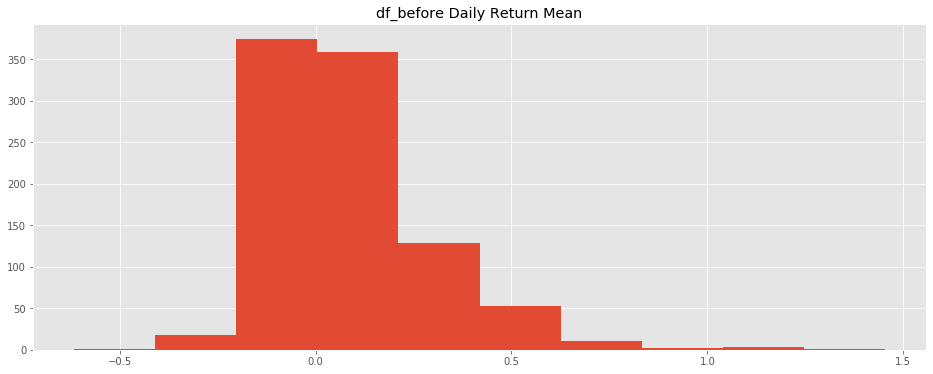

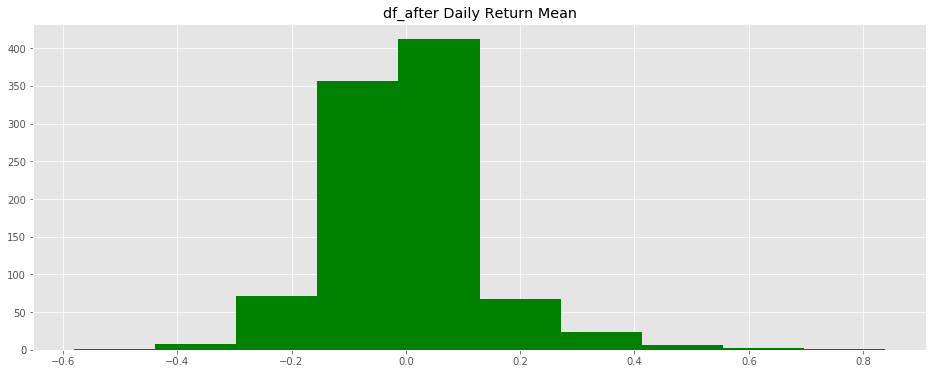

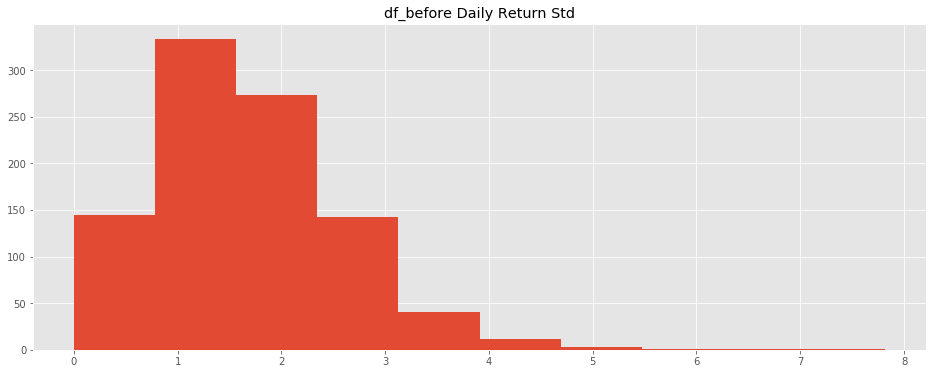

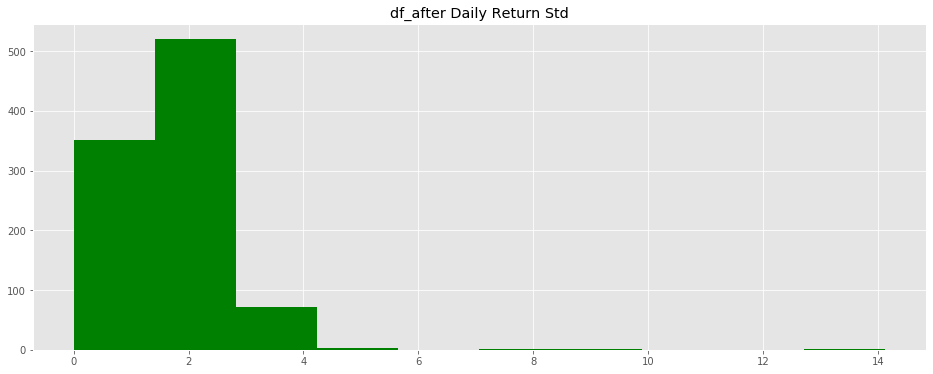

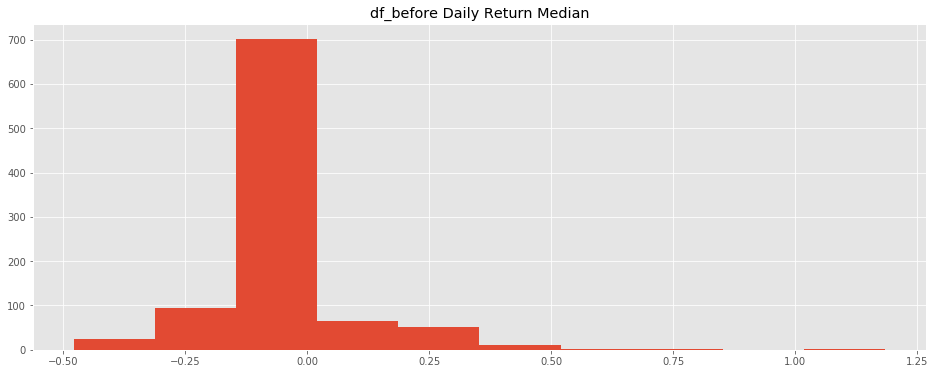

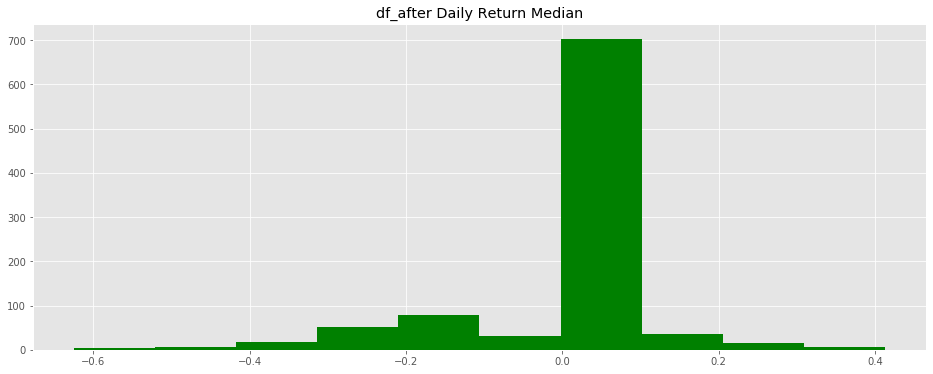

In [20]:
data_2 = tw_day_trade()
data_2.day_trade_split('2013/12/30','2014/6/30','2014/12/30')
data_2.day_trade_stats()
data_2.day_trade_calculate()
data_2.day_trade_plot('before','daily_mean')
data_2.day_trade_plot('after','daily_mean')
data_2.day_trade_plot('before','daily_std')
data_2.day_trade_plot('after','daily_std')
data_2.day_trade_plot('before','daily_median')
data_2.day_trade_plot('after','daily_median')
data_2.day_trade_OLS('daily')
data_2.day_trade_OLS('weekly')
data_2.day_trade_OLS('monthly')

### 2014/6/30 開放雙向當沖，前後各抓一年
#### **<span style="color:green">pos_1 = 2013/6/28, pos_2 = 2014/6/30, pos_3 = 2015/6/30</span>**

data 台灣上市公司總數: 950.0 間
data shape: (3800, 2393)
date_1 pos: 866
date_2 pos: 1113
date_3 pos: 1359
df_before shape: (3800, 247)
df after shape: (3800, 247)
{
  "mean": {
    "mean_before_daily": 0.10269688301725975,
    "mean_after_daily": -0.016387246764452114,
    "mean_before_weekly": 0.5264159650543363,
    "mean_after_weekly": 0.5264159650543363,
    "mean_before_monthly": 1.9980772162795652,
    "mean_after_monthly": -0.40363076919758417,
    "mean_cash": 0.6996795944779983
  },
  "std": {
    "std_before_daily": 1.6599577920106448,
    "std_after_daily": 1.7186600837386246,
    "std_before_weekly": 3.68901028141228,
    "std_after_weekly": 3.7726008711642556,
    "std_before_monthly": 7.636720257449635,
    "std_after_monthly": 7.34131030244174,
    "std_cash": 0.6183437627816176
  },
  "median": {
    "median_before_daily": -0.004904526315789474,
    "median_after_daily": -0.04094622907679034,
    "median_before_weekly": 0.15113402556999786,
    "median_after_weekly": -0.1898743

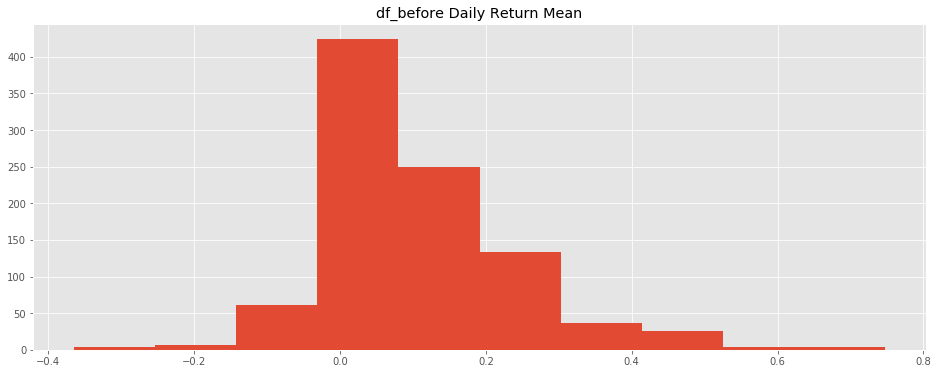

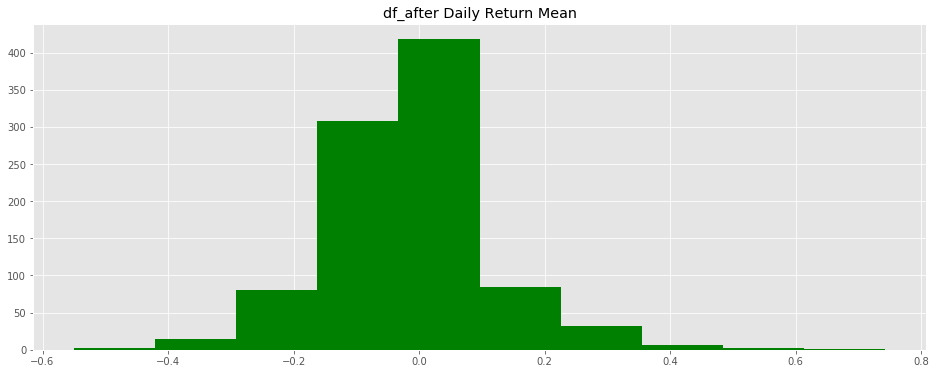

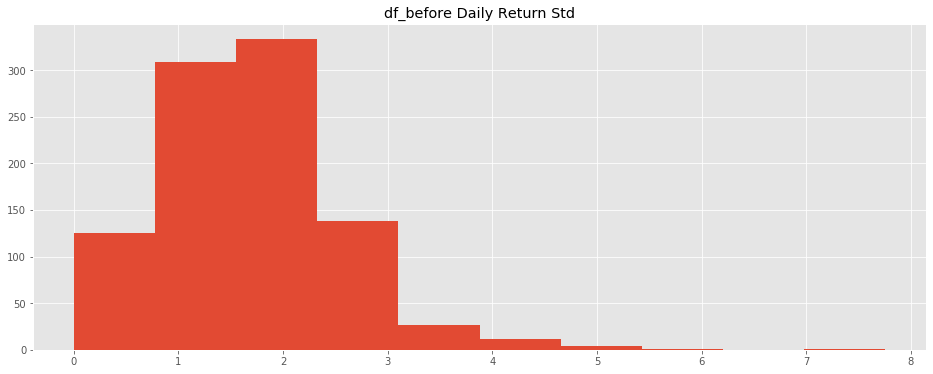

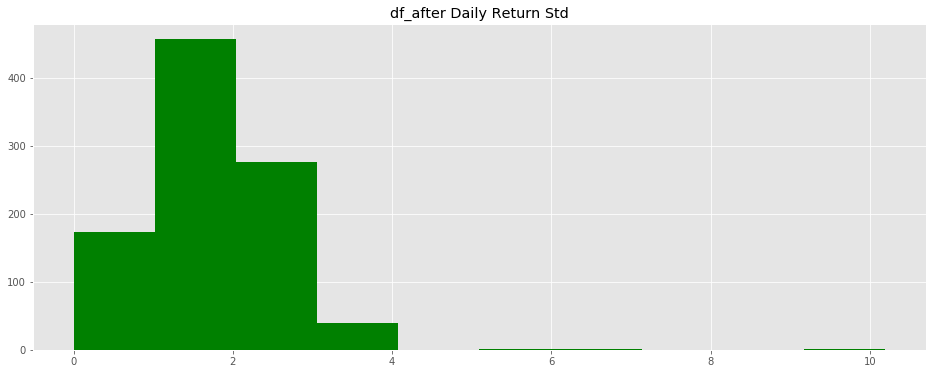

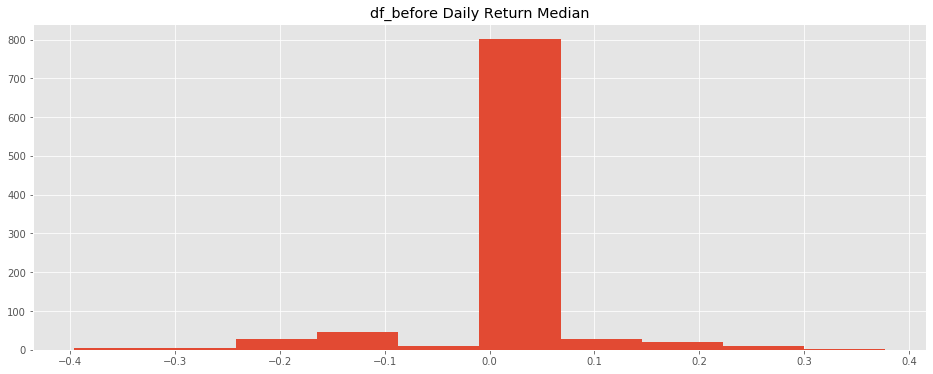

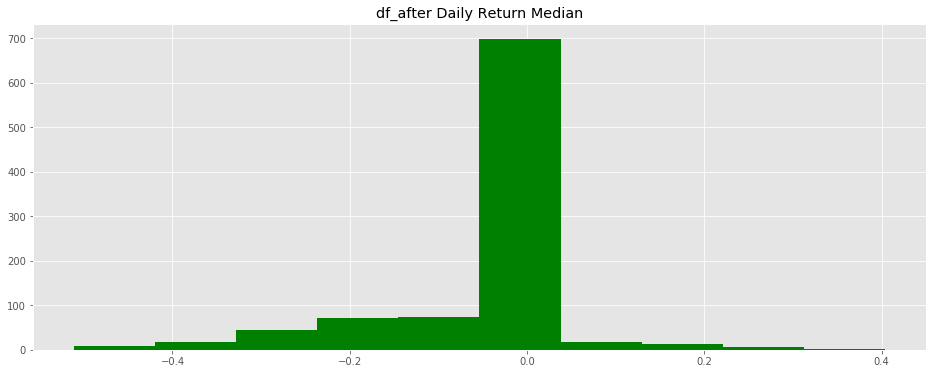

In [21]:
data_3 = tw_day_trade()
data_3.day_trade_split('2013/6/28','2014/6/30','2015/6/30')
data_3.day_trade_stats()
data_3.day_trade_calculate()
data_3.day_trade_plot('before','daily_mean')
data_3.day_trade_plot('after','daily_mean')
data_3.day_trade_plot('before','daily_std')
data_3.day_trade_plot('after','daily_std')
data_3.day_trade_plot('before','daily_median')
data_3.day_trade_plot('after','daily_median')
data_3.day_trade_OLS('daily')
data_3.day_trade_OLS('weekly')
data_3.day_trade_OLS('monthly')

### 2017/4/28 調降當沖稅率，前後各抓二年
#### **<span style="color:green">pos_1 = 2016/4/28, pos_2 = 2017/4/28, pos_3 = 2018/4/27</span>**

data 台灣上市公司總數: 950.0 間
data shape: (3800, 2393)
date_1 pos: 1316
date_2 pos: 1806
date_3 pos: 2296
df_before shape: (3800, 490)
df after shape: (3800, 491)
{
  "mean": {
    "mean_before_daily": -0.017993852416756172,
    "mean_after_daily": 0.01435494072247829,
    "mean_before_weekly": -0.07296326895810956,
    "mean_after_weekly": -0.07296326895810956,
    "mean_before_monthly": -0.4325021069817401,
    "mean_after_monthly": 0.4111768944152642,
    "mean_cash": 6.866000600278701
  },
  "std": {
    "std_before_daily": 1.329246748226727,
    "std_after_daily": 1.5844079819972174,
    "std_before_weekly": 3.0054217579254683,
    "std_after_weekly": 3.5201188822978065,
    "std_before_monthly": 5.91227692220706,
    "std_after_monthly": 7.270442247762863,
    "std_cash": 8.458226066408525
  },
  "median": {
    "median_before_daily": -0.0008414025778732547,
    "median_after_daily": -0.00017147368421052635,
    "median_before_weekly": 0.00018031578947368433,
    "median_after_weekly": 

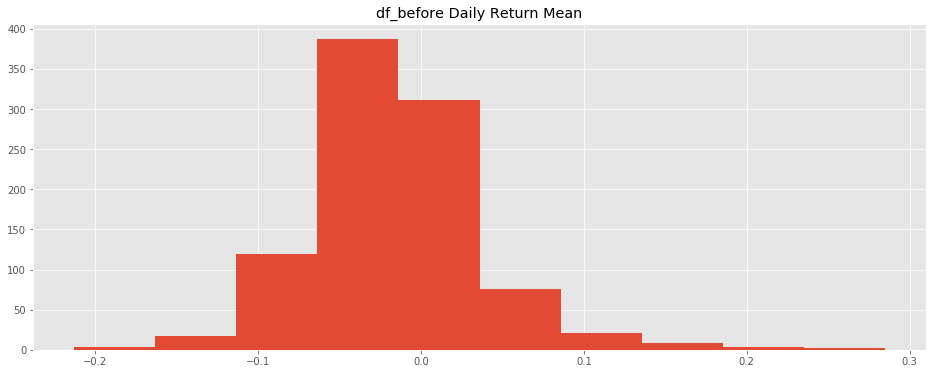

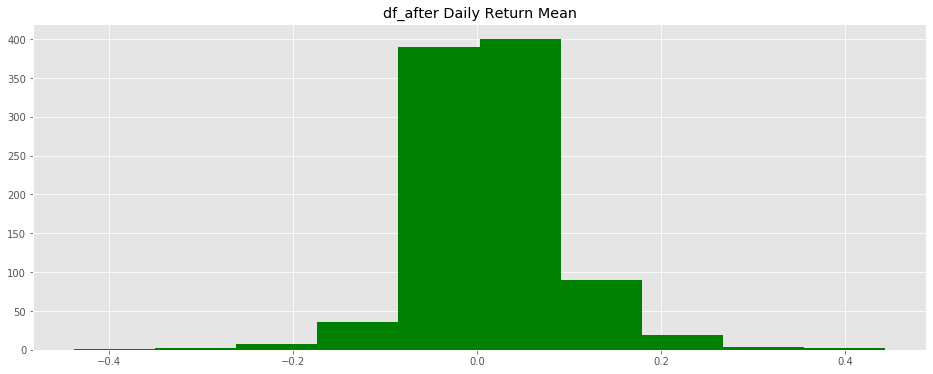

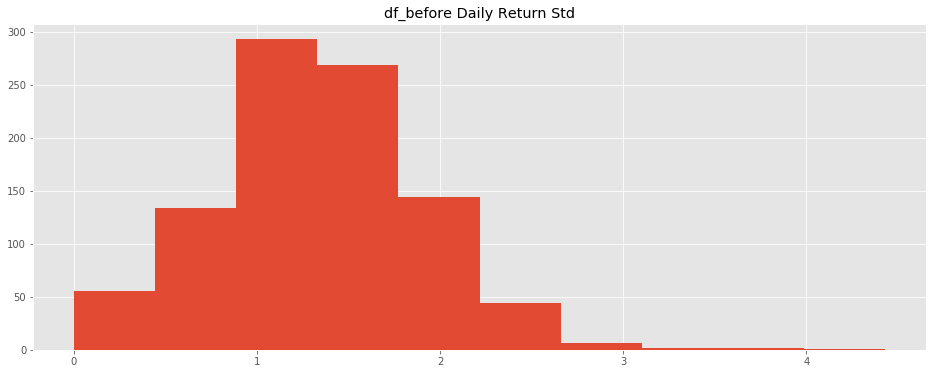

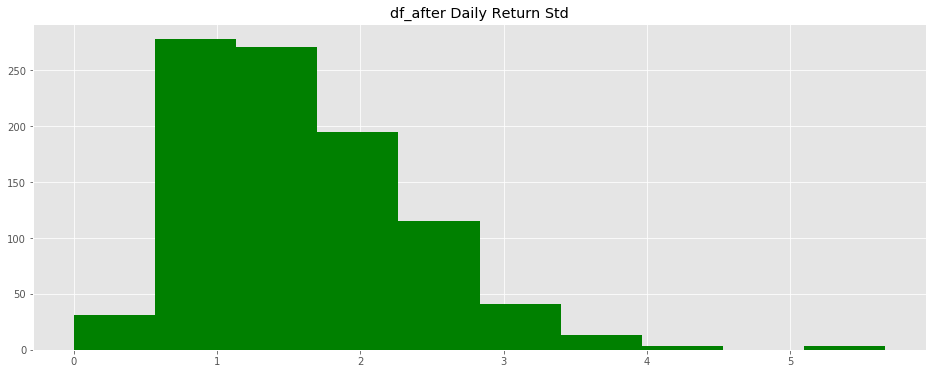

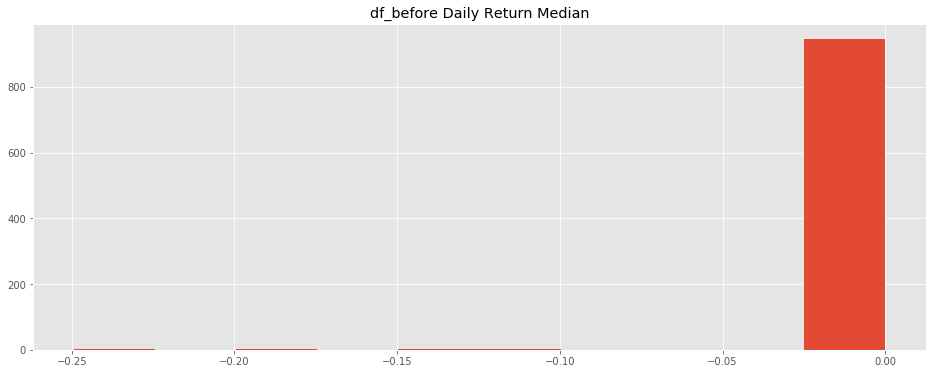

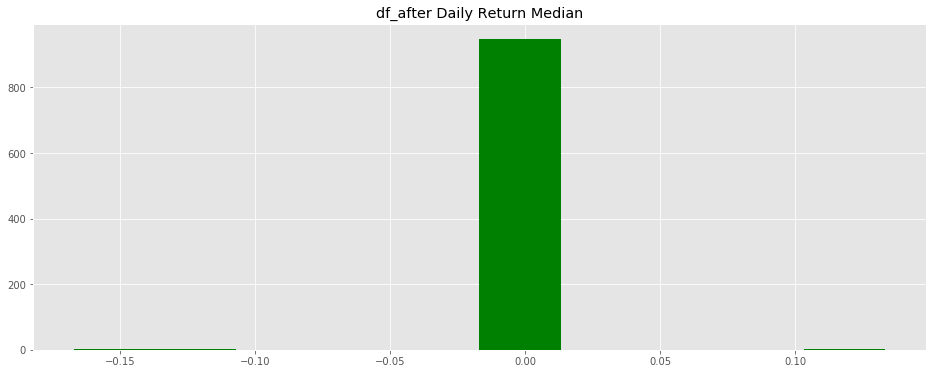

In [23]:
data_4 = tw_day_trade()
data_4.day_trade_split('2015/4/28','2017/4/28','2019/4/26')
data_4.day_trade_stats()
data_4.day_trade_calculate()
data_4.day_trade_plot('before','daily_mean')
data_4.day_trade_plot('after','daily_mean')
data_4.day_trade_plot('before','daily_std')
data_4.day_trade_plot('after','daily_std')
data_4.day_trade_plot('before','daily_median')
data_4.day_trade_plot('after','daily_median')
data_4.day_trade_OLS('daily')
data_4.day_trade_OLS('weekly')
data_4.day_trade_OLS('monthly')